In [4]:
import numpy as np
import sys
import os
import math
import pandas as pd
#import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
np.set_printoptions(threshold=sys.maxsize) # show full ndarray
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Inference

## Static: reason for the bent down beam

In [22]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return 1
    #return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

**Likelihood**

In [6]:
nsample = 20
sample_start = 15
sample_end = 300
height = 30
F = 256

<AxesSubplot:xlabel='Distance', ylabel='Height'>

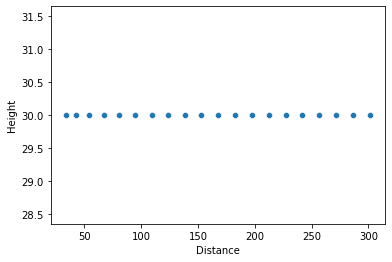

In [9]:
# Physical Beam
beam_depths = np.array(list(range(sample_start, sample_end+1, 15)))
beam_samples = np.sqrt(beam_depths**2 + height**2)  # radial distances for points on beam
phy_height = np.array([height] * nsample)

phy_beam = np.append(phy_height[:, None], beam_samples[:, None], axis=1)
column_values = ['Height', 'Distance']
phy_beam_df = pd.DataFrame(data = phy_beam, columns = column_values)
sns.scatterplot(data = phy_beam_df, x="Distance", y="Height")

In [15]:
# find the angles that are corresponding to the samples 
angles_phy = np.arctan(phy_height / beam_depths)
height = np.array(range(512))
angles_pri = np.arctan((height - F + 0.5) / F)

angles_index = list()
angles = list()
for angle in angles_phy:
    closest = min(angles_pri, key=lambda x:abs(x-angle))
    angles_index.append(list(angles_pri).index(closest))
    angles.append(closest)

In [12]:
angles

[0.7286994529784703,
 0.6167303302937971,
 0.5079272792730298,
 0.42057769235993514,
 0.3570572429475673,
 0.3046632370681827,
 0.2687293355778861,
 0.23945639988793785,
 0.21349300865926615,
 0.19476497591399516,
 0.17589755207658497,
 0.16451516467074306,
 0.14927195504006044,
 0.14162360642940994,
 0.13012000394304876,
 0.12243145760678886,
 0.11472833645809238,
 0.11087158344285233,
 0.1031482440926689,
 0.09928188012599641]

**Prior**

In [24]:
# the prior in the middle strip. i.e. the head is facing straight.
with np.load('prior_middle.npz') as npz:
    prior_middle = np.ma.MaskedArray(**npz)

**Posterior**

$E[p(d\mid o)] = \int d P(d \mid o) = \int d \dfrac{p(o \mid d)p(d)}{p(o)} \approx \sum d \dfrac{p(o \mid d)}{p(o)}$

where \
$P(o \mid d_i) \sim N(d_i, \sigma^2)$, and $p(o)=\Sigma_i p(o \mid d_i)p(d_i)$

In [23]:
variance = 20
posterior_means = list()
# for each distance sample (observed distance o) on the beam
for i in range(len(beam_samples)): 
    distance_phy = beam_samples[i]
    prior = prior_middle[angles_index[i]] / np.cos(angles[i]) # transform to radial distance
    # for each prior snapshot (inferred distance d)
    observed_prob = 0
    for j in range(1000):
        observed_prob += normal(distance_phy, prior[j], variance) * 1/1000
    print("=============")
    print("when physical distance is at", beam_samples[i], ", the P(o) is:", observed_prob)
    posterior_mean = 0    
    for j in range(1000):
        posterior_mean += prior[j] * normal(distance_phy, prior[j], variance) * (1/1000) / observed_prob 
    print("the approximated posterior mean is", posterior_mean)
    posterior_means.append(posterior_mean)
# print(posterior_means)

when physical distance is at 33.54101966249684 , the P(o) is: 1.0000000000000007
the approximated posterior mean is --
when physical distance is at 42.42640687119285 , the P(o) is: 1.0000000000000007
the approximated posterior mean is --
when physical distance is at 54.08326913195984 , the P(o) is: 1.0000000000000007
the approximated posterior mean is 11.14019551849364
when physical distance is at 67.08203932499369 , the P(o) is: 1.0000000000000007
the approximated posterior mean is 11.234400669574734
when physical distance is at 80.77747210701756 , the P(o) is: 1.0000000000000007
the approximated posterior mean is 11.407939600467671
when physical distance is at 94.86832980505137 , the P(o) is: 1.0000000000000007
the approximated posterior mean is 11.869041702747335
when physical distance is at 109.20164833920778 , the P(o) is: 1.0000000000000007
the approximated posterior mean is 12.288912070512767
when physical distance is at 123.69316876852982 , the P(o) is: 1.0000000000000007
the a